In [2]:
#!pip install keras==2.6.*

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

from tensorflow.data import Dataset
import keras

from keras.models import Model, Sequential
from keras.layers import Activation, Input, LeakyReLU, ConvLSTM2D, Conv2D, Reshape
import tensorflow.python.keras.backend as K

Populating the interactive namespace from numpy and matplotlib


In [106]:
Nt = 20 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image 
a = 3. ## scale factor for the size of particle spots (not true size of particles) 
IbackLevel = 0.1 ## relative intensity of randomly generated background pattern; in (0, 1) 
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2. ## the standard deviation for particle brownian motion; should be in (0, 10)

# Data Generation

In [111]:
def generate_data(size, pt, kappa, a, IbackLevel, Nparticles, sigma_motion): 
    all_vid, all_labels, all_tracks = [],[],[]
    for i in range(size): 
        vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 
        all_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
        all_labels.append(labels)
        all_tracks.append(tracks)
    all_vid = tf.convert_to_tensor(all_vid) 
    all_labels = tf.convert_to_tensor(all_labels) 
    all_tracks = tf.convert_to_tensor(all_tracks)
    
    all_vid = tf.expand_dims(all_vid, 4)
    all_labels = tf.squeeze(all_labels)
    return all_vid, all_labels, all_tracks

In [112]:
train_size = 20
val_size = 3
Nt = 10
pt = Particle_Tracking_Training_Data(Nt) 

train_vid, train_labels, train_tracks = generate_data(train_size, pt, kappa, a, IbackLevel, Nparticles, sigma_motion)
val_vid, val_labels, val_tracks = generate_data(val_size, pt, kappa, a, IbackLevel, Nparticles, sigma_motion)

# Basic CNN

In [113]:
#https://stackoverflow.com/questions/51793737/custom-loss-function-for-u-net-in-keras-using-class-weights-class-weight-not

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index  
        classSelectors = tf.cast(classSelectors, tf.int32)
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [114]:
precision_f = tf.keras.metrics.Precision(class_id=1)
recall_f = tf.keras.metrics.Recall(class_id=1)

def f1_score(y_true, y_pred):
    precision = precision_f(y_true, y_pred)
    recall = recall_f(y_true, y_pred)
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

In [115]:
train_vid_cnn = tf.reshape(train_vid, (train_size*Nt, 128, 128, 1))
train_labels_cnn = tf.reshape(train_labels, (train_size*Nt, 128, 128, 2))
val_vid_cnn = tf.reshape(val_vid, (val_size*Nt, 128, 128, 1))
val_labels_cnn = tf.reshape(val_labels, (val_size*Nt, 128, 128, 2))

In [116]:
loss_list1 = list()
acc_train_list1 = list()
recall_train_list1 = list()
prec_train_list1 = list()
f1_train_list1 = list()

class SaveBatchLoss1(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_list1.append(logs['loss'])
        acc_train_list1.append(logs['accuracy'])
        recall_train_list1.append(logs['recall_1'])
        prec_train_list1.append(logs['precision_1'])
        f1_train_list1.append(logs['f1_score'])

In [158]:
batch_size = 10
epochs = 50

model1 = Sequential()
model1.add(Input((128,128,1)))
model1.add(Conv2D(12, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model1.add(Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model1.add(Conv2D(2, 3, padding='same', strides=(1,1)))
model1.add(Activation('softmax'))

model1.compile(optimizer='adam',
             loss=weightedLoss(keras.losses.categorical_crossentropy, [0.2, 0.8]),
             metrics=['accuracy', tf.keras.metrics.Precision(name='precision_1', class_id=1), 
                      tf.keras.metrics.Recall(name='recall_1', class_id=1), f1_score])

num_batches = int(train_size/batch_size)
model1.fit(train_vid_cnn, train_labels_cnn, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid_cnn, val_labels_cnn), callbacks=SaveBatchLoss1())

Epoch 1/50
2/2 [==============================] - 97s 72s/step - loss: 8.7476 - accuracy: 0.9227 - precision_1: 9.8701e-04 - recall_1: 0.0189 - f1_score: 0.1070 - val_loss: 8.3601 - val_accuracy: 0.9947 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1069
Epoch 2/50
2/2 [==============================] - 7s 4s/step - loss: 10.1657 - accuracy: 0.9947 - precision_1: 6.3830e-04 - recall_1: 2.3796e-04 - f1_score: 0.1069 - val_loss: 8.5968 - val_accuracy: 0.9961 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1069
Epoch 3/50
2/2 [==============================] - 7s 4s/step - loss: 9.6394 - accuracy: 0.9955 - precision_1: 0.0014 - recall_1: 2.3796e-04 - f1_score: 0.1069 - val_loss: 6.9431 - val_accuracy: 0.9955 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1069
Epoch 4/50
2/2 [==============================] - 7s 4s/step - loss: 7.3567 - accuracy: 0.9944 - precision_1: 8.8905e-04 - recall_1: 3.9661e-04 - f1_s

2/2 [==============================] - 6s 3s/step - loss: 0.4292 - accuracy: 0.9900 - precision_1: 0.2215 - recall_1: 0.6403 - f1_score: 0.1085 - val_loss: 0.5341 - val_accuracy: 0.9884 - val_precision_1: 0.1532 - val_recall_1: 0.5546 - val_f1_score: 0.1086
Epoch 32/50
2/2 [==============================] - 6s 3s/step - loss: 0.4164 - accuracy: 0.9896 - precision_1: 0.2184 - recall_1: 0.6568 - f1_score: 0.1087 - val_loss: 0.5073 - val_accuracy: 0.9918 - val_precision_1: 0.2037 - val_recall_1: 0.5114 - val_f1_score: 0.1088
Epoch 33/50
2/2 [==============================] - 6s 3s/step - loss: 0.3971 - accuracy: 0.9927 - precision_1: 0.2905 - recall_1: 0.6140 - f1_score: 0.1090 - val_loss: 0.5004 - val_accuracy: 0.9934 - val_precision_1: 0.2456 - val_recall_1: 0.4892 - val_f1_score: 0.1090
Epoch 34/50
2/2 [==============================] - 7s 4s/step - loss: 0.3852 - accuracy: 0.9934 - precision_1: 0.3140 - recall_1: 0.6105 - f1_score: 0.1092 - val_loss: 0.4747 - val_accuracy: 0.9915 - va

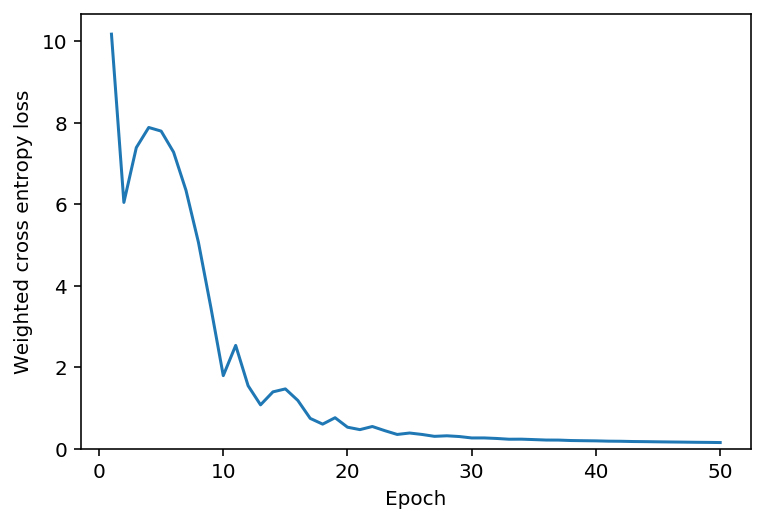

In [118]:
plt.plot(range(1,epochs+1), loss_list1[num_batches-1::num_batches])
plt.xlabel('Epoch')
plt.ylabel('Weighted cross entropy loss')
plt.ylim(0)
plt.show()

In [119]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 12)      120       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      3488      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 2)       578       
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 2)       0         
Total params: 4,186
Trainable params: 4,186
Non-trainable params: 0
_________________________________________________________________


# ConvLSTM2D

In [180]:
loss_list2 = list()
acc_train_list2 = list()
recall_train_list2 = list()
prec_train_list2 = list()
f1_train_list2 = list()

class SaveBatchLoss2(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_list2.append(logs['loss'])
        acc_train_list2.append(logs['accuracy'])
        recall_train_list2.append(logs['recall_1'])
        prec_train_list2.append(logs['precision_1'])
        f1_train_list2.append(logs['f1_score'])

In [27]:
# check which percentage is particles
num_part = tf.math.reduce_sum(train_labels[:,:,:,:,1])
print(1-num_part/(10*10*128*128))

tf.Tensor(0.9924664306640625, shape=(), dtype=float64)


In [181]:
batch_size = 2
epochs = 50

model2 = Sequential()
model2.add(Input((Nt,128,128,1)))
model2.add(ConvLSTM2D(12, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(ConvLSTM2D(16, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(ConvLSTM2D(2, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last', activation="softmax"))

model2.compile(optimizer='adam',
            loss=weightedLoss(keras.losses.categorical_crossentropy, [0.005, 0.995]),
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision_1', class_id=1), 
                      tf.keras.metrics.Recall(name='recall_1', class_id=1), f1_score])

num_batches = int(train_size/batch_size)
model2.fit(train_vid, train_labels, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid, val_labels), callbacks=SaveBatchLoss2())

Epoch 1/50
10/10 [==============================] - 148s 8s/step - loss: 0.0059 - accuracy: 0.9700 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1240 - val_loss: 0.0054 - val_accuracy: 0.9665 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1240
Epoch 2/50
10/10 [==============================] - 42s 4s/step - loss: 0.0055 - accuracy: 0.9627 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1240 - val_loss: 0.0048 - val_accuracy: 0.9651 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1240
Epoch 3/50
10/10 [==============================] - 40s 4s/step - loss: 0.0047 - accuracy: 0.9440 - precision_1: 0.2905 - recall_1: 0.0402 - f1_score: 0.1240 - val_loss: 0.0042 - val_accuracy: 0.9348 - val_precision_1: 0.2452 - val_recall_1: 0.0716 - val_f1_score: 0.1240
Epoch 4/50
10/10 [==============================] - 41s 4s/step - loss: 0.0041 - accuracy: 0.9287 - precision_1: 0.2919 - recall_1: 0.1555 - f1_score: 

Epoch 27/50
10/10 [==============================] - 40s 4s/step - loss: 0.0011 - accuracy: 0.9678 - precision_1: 0.3650 - recall_1: 0.4868 - f1_score: 0.1275 - val_loss: 0.0012 - val_accuracy: 0.9570 - val_precision_1: 0.2867 - val_recall_1: 0.3985 - val_f1_score: 0.1275
Epoch 28/50
10/10 [==============================] - 41s 4s/step - loss: 0.0011 - accuracy: 0.9697 - precision_1: 0.3799 - recall_1: 0.4716 - f1_score: 0.1276 - val_loss: 0.0012 - val_accuracy: 0.9609 - val_precision_1: 0.3166 - val_recall_1: 0.3627 - val_f1_score: 0.1277
Epoch 29/50
10/10 [==============================] - 40s 4s/step - loss: 0.0011 - accuracy: 0.9667 - precision_1: 0.3764 - recall_1: 0.4732 - f1_score: 0.1278 - val_loss: 0.0013 - val_accuracy: 0.9525 - val_precision_1: 0.2645 - val_recall_1: 0.4331 - val_f1_score: 0.1279
Epoch 30/50
10/10 [==============================] - 42s 4s/step - loss: 0.0022 - accuracy: 0.9284 - precision_1: 0.3549 - recall_1: 0.3882 - f1_score: 0.1279 - val_loss: 0.0025 - v

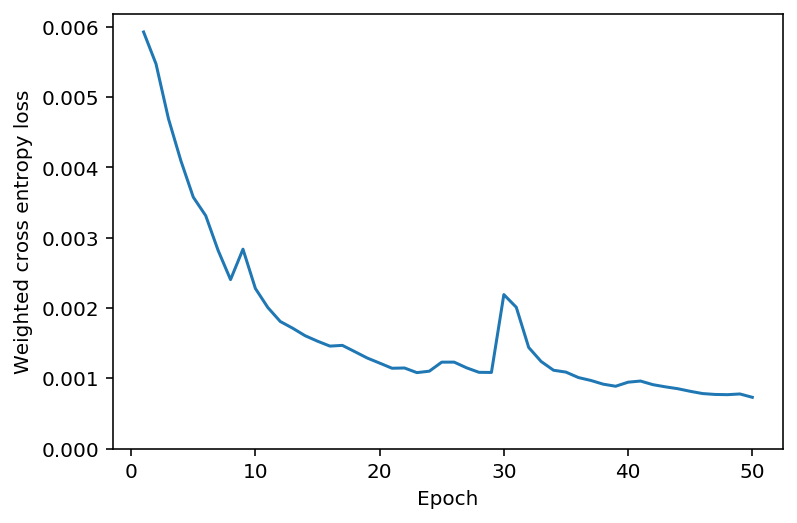

In [182]:
plt.plot(range(1,epochs+1), loss_list2[num_batches-1::num_batches])
plt.xlabel('Epoch')
plt.ylabel('Weighted cross entropy loss')
plt.ylim(0)
plt.show()

In [33]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_9 (ConvLSTM2D)  (None, 20, 128, 128, 12)  5664      
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 20, 128, 128, 16)  16192     
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, 20, 128, 128, 2)   1304      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 128, 128, 2)   0         
Total params: 23,160
Trainable params: 23,160
Non-trainable params: 0
_________________________________________________________________


## Visualize results

In [145]:
Nt = 20
pt_test = Particle_Tracking_Training_Data(Nt)
vid, labels, tracks = pt_test(kappa, a, IbackLevel, Nparticles, sigma_motion) 
input_vid = tf.expand_dims(vid[:,::2,::2], 3)

In [174]:
# get model predictions
#pred = model1.predict(input_vid)
pred = model2.predict(tf.expand_dims(input_vid,0))[0]

In [175]:
# convert predictions to binary output
threshold = 0.5
pred_bin = pred.copy()
pred_bin[pred_bin <= threshold] = 0
pred_bin[pred_bin > threshold] = 1

In [178]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    #if show_tracks:
    #    plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(0, 255)
    ylim(0, 255)
    plt.title('Input image', fontsize=25)
        
    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(pred_bin[t, ..., 1], origin='lower')
    plt.title('Predicted particles', fontsize=25)
    
    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')
    plt.title('Ground truth', fontsize=25)
    
    plt.savefig('img'+str(t)+'_lstm.png')

interactive(children=(IntSlider(value=0, description='t', max=19), Checkbox(value=True, description='show_trac…